# Unit 4: Identifying Trends and Creating Models

## Contents

* [Getting Started](#Getting-Started)
* [Linear Models](#Linear-Models)
    * [An Example](#An-Example)
    * [Simple Linear Regression](#Simple-Linear-Regression)
    * [Multiple Linear Regression](#Multiple-Linear-Regression)
    * [Linear-Like Regression](#Linear-Like-Regression)
* [Logistic Regression](#Logistic-Regression)
    * [An Example](#An-Example)
    * [Home Data](#Home-Data)
* [Lab Answers](#Lab-Answers)
* [Next Steps](#Next-Steps)
* [Resources and Further Reading](#Resources-and-Further-Reading)
* [Notes](#Notes)
* [Exercises](#Exercises)

### Lab Questions

## Getting Started

In previous units, we worked on loading, cleaning, and exploring data.  While working with the data, we noted that certain relationships appeared to exist between columns/variables.  While plots allowed us to make claims like "x increases as y decreases",  we didn't try to model that relationship mathematically nor did we try to determine the quality of that model.  

In this unit,we'll look at creating models for the relationships in our data; specifically, we'll look at linear models for numerical data and logistic models for categorical data.

To create and explore these models, we'll use the [StatsModels](https://www.statsmodels.org/stable/index.html) library. To install it, we'll use `!pip`.

In [1]:
!pip install statsmodels

  Using cached statsmodels-0.8.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached patsy-0.5.0-py2.py3-none-any.whl


We'll work with plots in this unit.  To ensure they are displayed in the notebook itself, we'll need to use the `%matplotlib inline` command.

In [2]:
%matplotlib inline

In addition to the Seaborn and pandas libraries, we'll make explicit use of libraries on which they depend.

- [matplotlib.pyplot](https://matplotlib.org/api/pyplot_api.html): a collection of plotting functions with [MATLAB](https://www.mathworks.com/products/matlab.html)-like syntax
- [numpy](http://www.numpy.org/): scientific computing library

We'll import these and StatsModels with names that follow standard convention.

We also set the figure size for plots and a marker size for outliers in box plots.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(12,8), "lines.markeredgewidth": 0.5 })


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Linear Models

The first type of model we'll look at are linear models also known as linear regressions. In basic terms,  we use a linear model if the data looks like a line could be drawn through it.  More specifically, for two dimensional data, we try to model the relationship between two variables, the independent or input variable, *X*, and the dependent or response variable, *Y*, by an equation of the form 

$$
\begin{array}{c}
Y = \beta_0 + \beta_1 X
\end{array}
$$

where $\beta_0$ and $\beta_1$ are *coefficients*. We can generalize this to more than two dimensions. If $X_1, X_2, \ldots, X_n$ are independent variables, and $Y$ is the dependent variable, we try to model the relationship by an equation in the form

$$
\begin{array}{c}
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_n X_n
\end{array}
$$

where $\beta_0, \beta_1, \ldots, \beta_n$ are the coefficients.

To find the coefficients of these equations, we'll rely on the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) method that attempts to minimizing the the sum of squares of the differences between the observed values and the predicted values - we'll explore this further in a bit.

### An Example

Let's look at an example of how we can calculate the coefficients of a linear equation that models some data. We'll start with an example based on the [StatsModels documentation](http://www.statsmodels.org/stable/examples/notebooks/generated/ols.html).

First, we generate our "observed" data.  To do this, we'll use the Numpy [*linspace()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) function to generate 100 evenly-spaced values between 0 and 10; these will correspond to values that will be used for the independent variable.  Next, we'll use the [*normal()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function from NumPy's [*random*](https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html) submodule to draw 100 samples from a normal distribution - this will simulate errors in our data.

In [76]:
nsample = 100
x = np.linspace(0, 10, nsample)
e = np.random.normal(size=nsample)

display(x[:10])

array([0.        , 0.1010101 , 0.2020202 , 0.3030303 , 0.4040404 ,
       0.50505051, 0.60606061, 0.70707071, 0.80808081, 0.90909091])

Looking at the first 10 values of `x`, we can see that they are stored in an [array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.array.html).

Next, we calculate our "observed" values as a combination of the independent variable, a constant, and some error.

In [77]:
y = 5 * x + 3 + e

Let's plot the values of `x` and `y`.  We'll create a scatter plot but use a different approach to do this.  

First, we create [figure](https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure) and [axes](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes) objects using the pyplot [*subplots()*](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) function; this is useful when we want to plot items from different sources together (as we will do in a bit). We use the axes' [*plot()*](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.plot.html#matplotlib.axes.Axes.plot) method to plot the coordinate pairs from `x` and `y`; the third argument indicates that we'd like to use blue plus-sign markers rather than draw lines from the data.

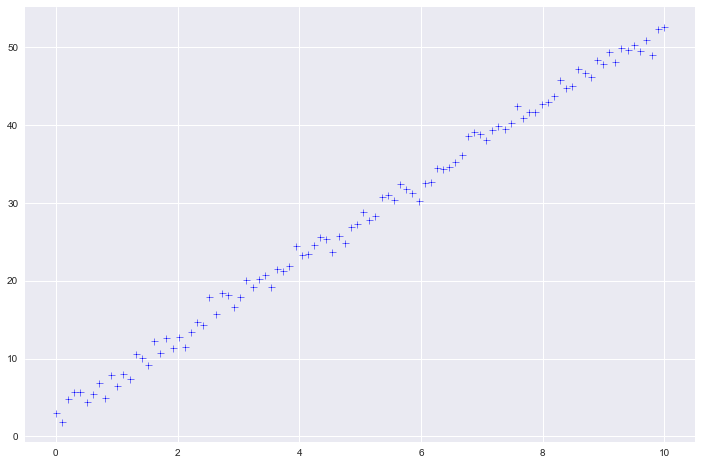

In [78]:
fig, ax = plt.subplots()
ax.plot(x, y, 'b+')

In the two-dimensional linear regression. we need to calculate the values of two coefficients: a constant and a value that will be multiplied by the value of the independent variable.  As we saw above, we can write the linear model in the form

$$
\begin{array}{c}
Y = \beta_0 + \beta_1 X
\end{array}
$$

We can write the constant, $\beta_0$ as $\beta_0 X^0$  Since any value raised to the zeroth power is one, we can write $\beta_0$ as $1 \cdot \beta_0$.  We can say that the dependent variable is a linear combination of 1 and the independent variable.  For our model, we account for this by using the StatsModels' [*add_constant()*](http://www.statsmodels.org/dev/generated/statsmodels.tools.tools.add_constant.html) function. 

In [79]:
X = sm.add_constant(x)
display(X[:10])

array([[1.        , 0.        ],
       [1.        , 0.1010101 ],
       [1.        , 0.2020202 ],
       [1.        , 0.3030303 ],
       [1.        , 0.4040404 ],
       [1.        , 0.50505051],
       [1.        , 0.60606061],
       [1.        , 0.70707071],
       [1.        , 0.80808081],
       [1.        , 0.90909091]])

Comparing `X` to `x` we now have an array of arrays where the first element in the inner arrays are `1` corresponding to the value of the independent variable for the constant term. 

To compute the the linear regression, we first set up the ordinary least squares model using the StatsModels' [*OLS*](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) function and by specifying the array of values for the dependent variable and the array of values for the independent variable.  

With the model created, we calculate the regression coefficients using the model's [*fit()*](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit) method; this method returns a [*RegressionResults*](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html) object. To dispaly information about the fit, we display the output of the result's [*summary()*](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.summary.html#statsmodels.regression.linear_model.RegressionResults.summary) method.

In [80]:
model = sm.OLS(y, X)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.062e+04
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          9.44e-116
Time:                        22:00:09   Log-Likelihood:                -142.52
No. Observations:                 100   AIC:                             289.0
Df Residuals:                      98   BIC:                             294.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8148      0.202     13.950      0.000       2.414       3.215
x1             5.0060      0.035    143.598      0.000       4.937       5.075
==============================================================================
Omnibus:                        0.430   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.231
Skew:                          -0.115   Prob(JB):                        0.891
Kurtosis:                       3.047   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the results, the coefficients, their p-values, and the value of `R-squared` are particularly of interest.  We can access these directly from `results` using the *params*, *pvalues*, and *rsquared* properties as well.

In [81]:
print('Parameters: ', results.params)
print("P-values:", results.pvalues)
print('R^2: ', results.rsquared)

Parameters:  [2.81476968 5.00603465]
P-values: [5.18484549e-025 9.43755992e-116]
R^2:  0.995269903144755


The coefficients appear in the same order in which the independent variables appear in `X`.

Note that this is "close" to the equation we used to generate the data - the discrepancy is due to the error we introduced.  

Let's plot the regression line along with our data.  We can repeat the same steps as before to create the scatter plot.  We make an additional call to *plot()* and specify the y-values as the output from the results *predict()* method which returns the predicted values of the dependent variable based on the regression results.  Specifying `'r'` for the third argument to plot indicates that we would like the line to be red.  

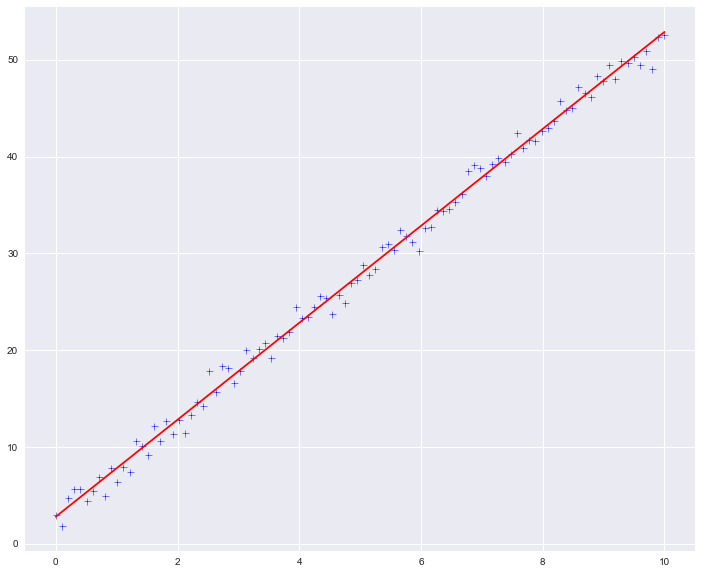

In [82]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(x, y, 'b+')
ax.plot(x, results.predict(), 'r')

The [p-value](https://en.wikipedia.org/wiki/P-value) associated with each coefficient indicates how likely changes to the corresponding independent variable account for changes in the dependent variable.  A p-value close to zero (typically, less than 0.05) indicates that the independent variable provides a meaningful addition to the model. <sup><a href="#note-1">1</a></sup>

The `R-squared` value is also known as the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) and provides a measure of how well the regression line fits the data.  The coefficient of determination can range from 0 to 1 with 0 indicating (in some regressions, the value can be negative) and indicates how much of the variation in dependent variable can be explained by the model - a value of 1 indicates that all variation is explained by the model and 0 indicates that the model accounts for none of the variation. In this example, some of the variation is due to the error we introduced - changing the magnitude of the error or the parameters of the distribution from which values were drawn will result in a better or worse coefficient of determination.

### Simple Linear Regression

Let's look at an example based on real data.  To begin, we'll load the fuel economy data we processed previously.

In [234]:
epa_data = pd.read_csv("./data/02-vehicles.csv", engine="python")

Recall that a description of the data is available in `./data/02-vehicles-description.html`.

In [235]:
from IPython.display import HTML
HTML(filename="./data/02-vehicles-description.html")

For this unit, we'll work the the following columns.

- `co2`
- `comb08`
- `cylinders`
- `displ`
- `highway08`
- `city08`

We can also remove rows with missing or non-positive values.  Because the DataFrame consists of only numeric data, we can use a sort of shortcut for removing rows with non-positive values.  We create a mask applied to the entire DataFrame rather than a specific column - this applies it to all columns.  We then use *all()* with an argument of 1 to indicate that the property applies across all columns.  Effectively this mask will match any row in which all the values are positive.

In [244]:
epa_subset = epa_data[['co2', 'comb08', 'cylinders', 'displ', 'highway08', 'city08']].copy()
epa_subset = epa_subset[(epa_subset > 0).all(1)].copy()
epa_subset.head()

,co2,comb08,cylinders,displ,highway08,city08
16780,318,32,4.0,2.0,37,29
16781,315,32,4.0,2.0,39,29
16839,318,32,4.0,2.0,37,29
16840,315,32,4.0,2.0,39,29
21337,315,32,4.0,2.0,39,29


To start, let's look at a pair plot for the `co2`, `comb08`, `cylinders`, and `displ` columns in `epa_subset`. 

<hr>
<a name="Lab-1"></a><mark> **Lab 1** In the cell below, create a pair plot for the `co2`, `comb08`, `cylinders`, and `displ` columns in `epa_subset`.
</mark>

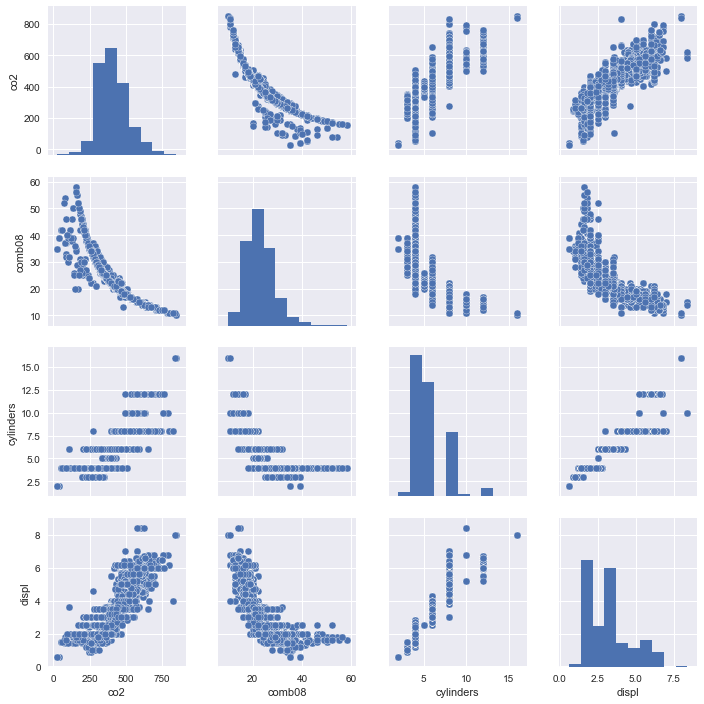

In [245]:
sns.pairplot(data=epa_subset[['co2', 'comb08', 'cylinders', 'displ']])

<hr>

Let's look more closely at the relationship between `Cylinders` and `Displacement`.

<hr>
<a name="Lab-2"></a><mark> **Lab 2** In the cell below, create scatter plot for the `cylinders` and `displacement` columns in `epa_subset`.
</mark>

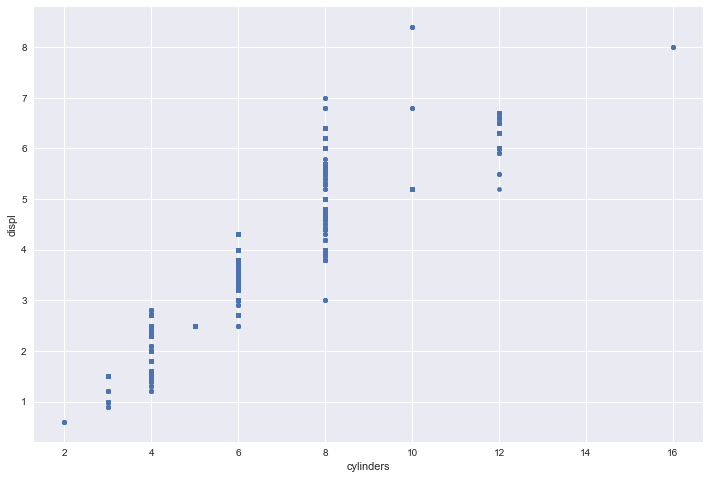

In [246]:
epa_subset.plot.scatter(x='cylinders', y='displ')

<hr>

Next, lets create the least squares model and fit a line to the data.




In [268]:
X = sm.add_constant(epa_subset.cylinders)
Y = epa_subset.displ
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  displ   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 4.527e+04
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:01:22   Log-Likelihood:                -5593.4
No. Observations:                7402   AIC:                         1.119e+04
Df Residuals:                    7400   BIC:                         1.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6751      0.019    -35.240      0.000      -0.713      -0.638
cylinders      0.6834      0.003    212.759      0.000       0.677       0.690
==============================================================================
Omnibus:                      488.472   Durbin-Watson:                   0.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1327.138
Skew:                           0.364   Prob(JB):                    6.54e-289
Kurtosis:                       4.942   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the `R-squared` value we can see there is a somewhat strong linear relationship between the data; further, the p-value for the coefficient of `cylinders` indicates that changes in `dislp` are likely attributed to changes in `cylinders`.  

To plot the fit line with the scatter plot generated by the DataFrame's *plot()* method we can use StatsModel's [*abline_plot()*](http://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.abline_plot.html) function.  First, we import the function then create a scatter plot and store the returned *axes* object.

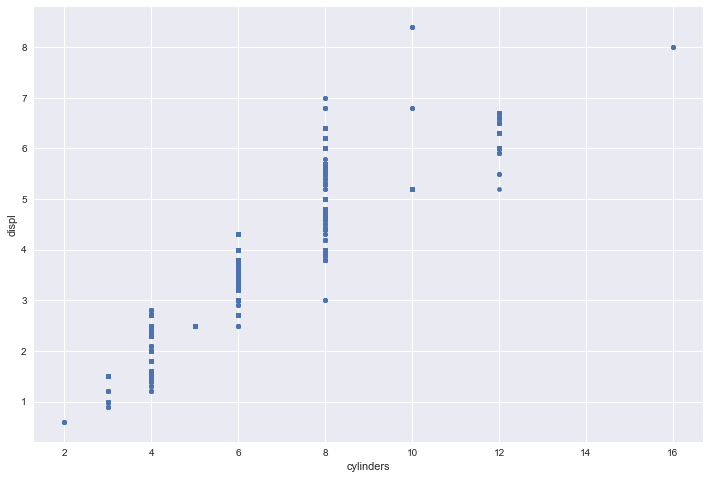

In [253]:
from statsmodels.graphics.regressionplots import abline_plot
axes = epa_subset.plot.scatter(x="cylinders", y="displ")

We can can add the plot of the regression line to the plot using *abline_plot()* function, specifying the model results, the *axes*, and a color.

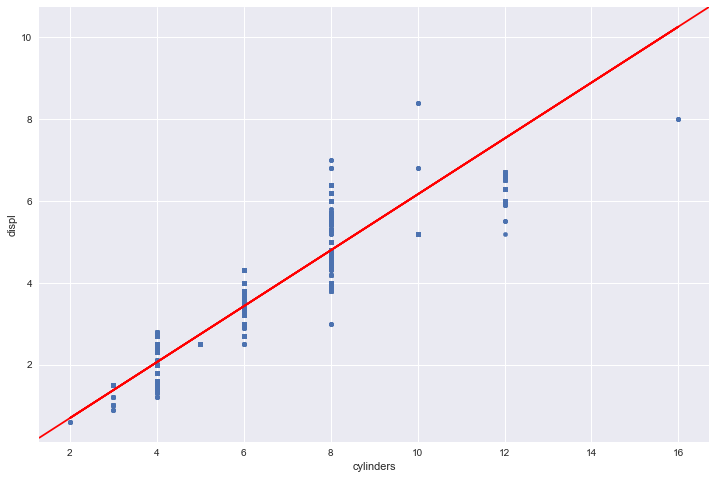

In [256]:
abline_plot(model_results=res, ax=axes, color='r')

Often when creating models, we want to exclude outliers in our calculations.  Let's look at the box plots for `cylinders` and `displ`.

<hr>
<a name="Lab-3"></a><mark> **Lab 3** In the cells below, create the box plots for `cylinders` and `displ`.</mark>

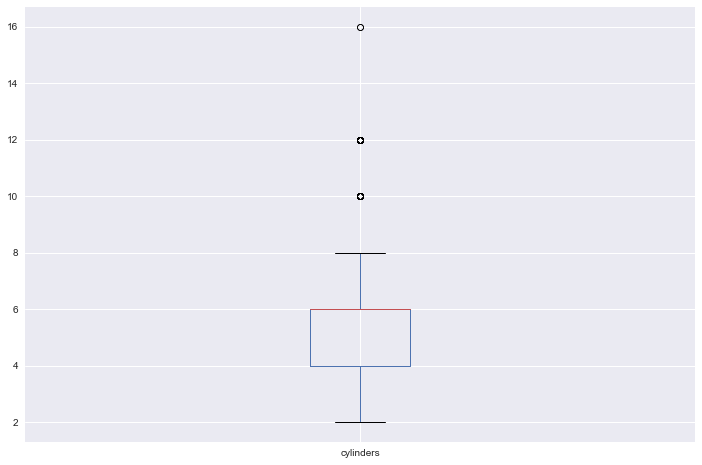

In [258]:
epa_subset.cylinders.plot(kind='box')

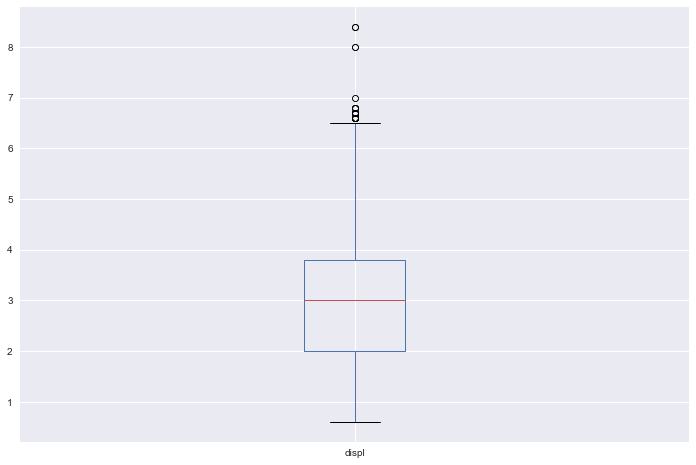

In [259]:
epa_subset.displ.plot(kind='box')

<hr>

We can see that there are a few outliers for each column.  We can remove them and recalculate the fit.  We can create a copy of the DataFrame from which will will remove outliers.

In [261]:
epa_no_outliers = epa_subset[['cylinders', 'displ']].copy()

To remove the outliers from a column, we'll create a function that we can apply to a DataFrame.  We'll define outliers based on the interquartile range. 

After defining the function, we can use it with our `epa_no_outliers` DataFrame.

In [263]:
def remove_outliers(dataframe, column):
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return dataframe[(dataframe[column] >= lower) &
                     (dataframe[column] <= upper)].copy()

epa_no_outliers = remove_outliers(epa_no_outliers, "cylinders")
epa_no_outliers = remove_outliers(epa_no_outliers, "displ")

With the outliers removed, we can create a new model and calculate the regression coefficients. 

<hr>
<a name="Lab-4"></a><mark> **Lab 4** In the cell below, create an ordinary least squares model where `cylinders` is the independent variable and `displ` is the dependent variable. Include a coefficient term in the model. Calculate the fit and store the result in a variable named `res_no_outliers`.</mark>

In [269]:
X = sm.add_constant(epa_no_outliers.cylinders)
Y = epa_no_outliers.displ
est = sm.OLS(Y, X)
res_no_outliers = est.fit()

Looking at the result's summary and the `R-squared` value, we can see the the fit is slightly better with the outliers removed. 

In [270]:
display(res_no_outliers.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  displ   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 5.384e+04
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:01:45   Log-Likelihood:                -4103.9
No. Observations:                7132   AIC:                             8212.
Df Residuals:                    7130   BIC:                             8225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1141      0.019    -59.314      0.000      -1.151      -1.077
cylinders      0.7681      0.003    232.042      0.000       0.762       0.775
==============================================================================
Omnibus:                      104.759   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.838
Skew:                           0.167   Prob(JB):                     3.93e-34
Kurtosis:                       3.637   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can plot both the original fit and the fit calculated without outliers against a scatter plot of the data.

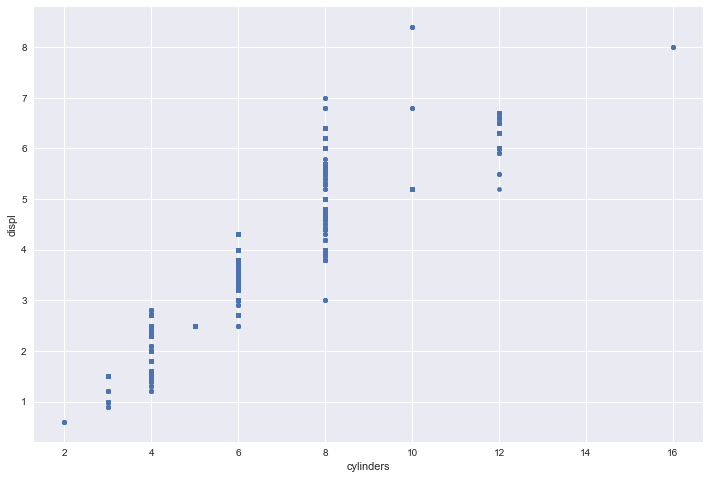

In [271]:
axes = epa_subset.plot.scatter(x="cylinders", y="displ")

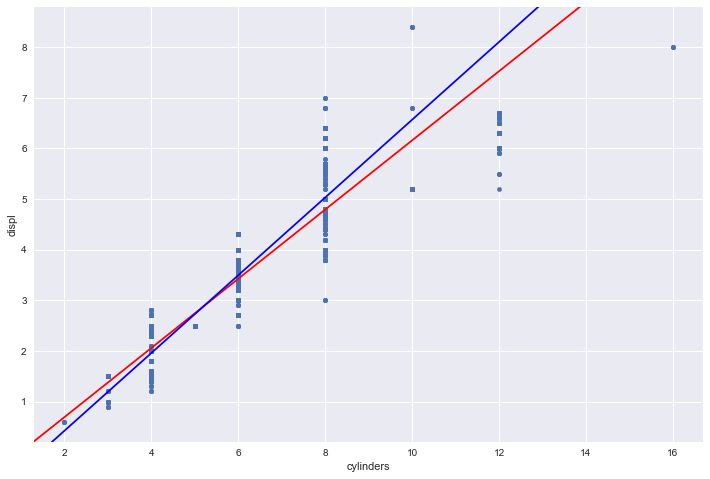

In [272]:
abline_plot(model_results=res, ax=axes, color='r')
abline_plot(model_results=res_no_outliers, ax=axes, color='b')

The original regression line is colored red and the regression line calculated with outliers removed is colored blue.

### Multiple Linear Regression

So far, we've looked at regressions in which there is one independent variable and a constant.  Often, changes in the response variable are dependent on multiple variables.  For example. we expect that the combined fuel economy is dependent on both city and highway economy. We can see from the scatter plots that `comb08` looks linearly dependent on `city08` and `highway08`.

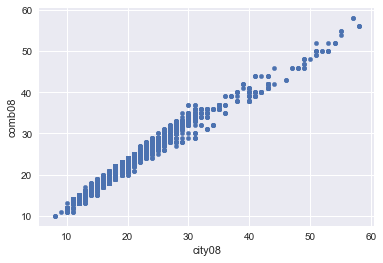

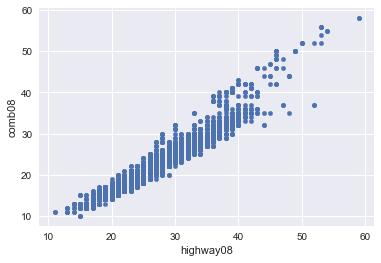

In [281]:
epa_subset.plot.scatter(x='city08', y='comb08')
epa_subset.plot.scatter(x='highway08', y='comb08')

We can also fit models for each of these individually - `city08`/`comb08` and `highway08`/`comb08`.

In [282]:
X = sm.add_constant(epa_subset.city08)
Y = epa_subset.comb08
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 2.590e+05
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:45:46   Log-Likelihood:                -10242.
No. Observations:                7402   AIC:                         2.049e+04
Df Residuals:                    7400   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9449      0.041     71.791      0.000       2.865       3.025
city08         0.9854      0.002    508.942      0.000       0.982       0.989
==============================================================================
Omnibus:                     1685.615   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6373.261
Skew:                          -1.096   Prob(JB):                         0.00
Kurtosis:                       6.982   Cond. No.                         77.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [284]:
X = sm.add_constant(epa_subset.highway08)
Y = epa_subset.comb08
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 9.094e+04
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:46:05   Log-Likelihood:                -13930.
No. Observations:                7402   AIC:                         2.786e+04
Df Residuals:                    7400   BIC:                         2.788e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6589      0.087    -30.508      0.000      -2.830      -2.488
highway08      0.9307      0.003    301.560      0.000       0.925       0.937
==============================================================================
Omnibus:                     2766.126   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17613.587
Skew:                           1.653   Prob(JB):                         0.00
Kurtosis:                       9.796   Cond. No.                         133.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
X = sm.add_constant(epa_subset[['city08', 'displ', 'comb08']])
Y = epa_subset.co2
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 2.137e+04
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:24:40   Log-Likelihood:                -34426.
No. Observations:                7132   AIC:                         6.886e+04
Df Residuals:                    7128   BIC:                         6.889e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        606.8635      3.895    155.793      0.000     599.228     614.500
cylinders      2.3894      0.687      3.478      0.001       1.043       3.736
displ         19.3059      0.862     22.404      0.000      17.617      20.995
comb08       -11.9310      0.099   -120.602      0.000     -12.125     -11.737
==============================================================================
Omnibus:                     1530.513   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35259.651
Skew:                           0.453   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         270.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Separately, the models fit the data quite well.  Let's look at the model in which both `city08` and `highway08` are independent variables.

In [285]:
X = sm.add_constant(epa_subset[['city08', 'highway08']])
Y = epa_subset.comb08
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 8.489e+05
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:49:46   Log-Likelihood:                -3370.7
No. Observations:                7402   AIC:                             6747.
Df Residuals:                    7399   BIC:                             6768.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0860      0.022     -3.874      0.000      -0.130      -0.042
city08         0.6466      0.002    347.731      0.000       0.643       0.650
highway08      0.3600      0.002    199.909      0.000       0.356       0.364
==============================================================================
Omnibus:                      101.613   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.826
Skew:                          -0.059   Prob(JB):                     2.28e-14
Kurtosis:                       2.564   Cond. No.                         177.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the coefficient of determination, we can see this model, which depends on both `city08` and `highway08`, fits the data better than a model which depends on only one of the variables.

### Linear-Like Regression

While there are many of relationships that are linear and that can be modeled using a linear regression, there are also relationships that are non-linear.  Among these non-linear relationships are those that can transformed into a linear ones in terms of the coefficients and independent variables.

As an example, consider the relationship between `comb08` and `c02`.

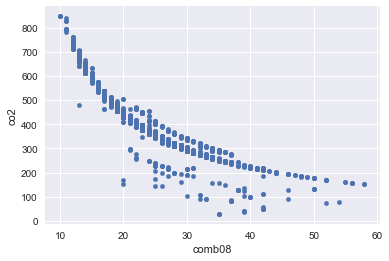

In [286]:
epa_subset.plot.scatter(x="comb08", y="co2")

While this relationship doesn't appear to be linear, it does look [hyperbolic](https://en.wikipedia.org/wiki/Hyperbola). In this case, the relationship between the independent variable and dependent variable could be written as 


$$
\begin{array}{c}
Y = \frac{1}{\beta_0 + \beta_1 X}
\end{array}
$$

To move the coefficients and independent variable out of the denominator, we can take the reciprocal of both sides (provided the neither side is zero) - this gives us


$$
\begin{array}{c}
\frac{1}{Y} = \beta_0 + \beta_1 X
\end{array}
$$

For a given observation, this form is easier to work with since $\frac{1}{Y}$ and $X$ are constants and we need to solve for $\beta_0$ and $\beta_1$. 

We can calculate the reciprocal of the dependent variable, `co2`, and store the value in a new column.

In [310]:
epa_non_linear = epa_subset[['comb08', 'co2']].copy()

In [318]:
epa_non_linear["reciprocal_co2"] = 1/epa_non_linear.co2

Looking at the plot of `comb08` and `reciprocal_c02`, it appears that the relationship is linear, which supports our assumption that the original relationship was hyperbolic.

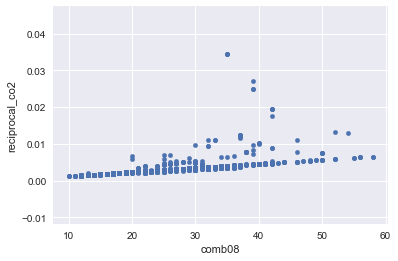

In [319]:
epa_non_linear.plot.scatter(x="comb08", y="reciprocal_co2")

Before fitting the data with a linear model, let's remove the outliers.

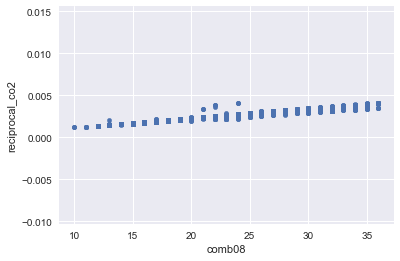

In [321]:
epa_non_linear = remove_outliers(epa_non_linear, "comb08")
epa_non_linear = remove_outliers(epa_non_linear, "reciprocal_co2")
axes = epa_non_linear.plot.scatter(x="comb08", y="reciprocal_co2")

We can now create a linear model for `comb08` and `reciprocal_c02`.  After calculating the coefficients, we display the summary of the results.

In [352]:
X = sm.add_constant(epa_non_linear["comb08"])
Y = epa_non_linear["reciprocal_co2"]
est = sm.OLS(Y, X)
res = est.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         reciprocal_co2   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 2.804e+05
Date:                Wed, 04 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:26:12   Log-Likelihood:                 56992.
No. Observations:                7193   AIC:                        -1.140e+05
Df Residuals:                    7191   BIC:                        -1.140e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.764e-05   4.77e-06     14.182      0.000    5.83e-05     7.7e-05
comb08         0.0001   2.06e-07    529.486      0.000       0.000       0.000
==============================================================================
Omnibus:                     4638.856   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1442146.541
Skew:                           1.921   Prob(JB):                         0.00
Kurtosis:                      72.261   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the coefficient of determination, we see that the model produced a good fit. Adding the regression line to the existing scatter plot give the following plot.

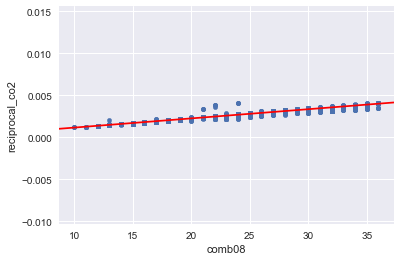

In [324]:
abline_plot(model_results=res, ax=axes, color='r')

We now need to transform the regression line to fit the original data.  Using the *params* property of the results we have the following constant term and coefficient.

In [349]:
res.params

const     0.000068
comb08    0.000109
dtype: float64

This means that our model is 

$$
\begin{array}{c}
Y = \frac{1}{0.000068 + 0.000109 X}
\end{array}
$$

We can calculate the predicted values from our model using the following code.  We use *sort_values()* to ensure that the values of the independent variable are in order. This will be important when we plot the curve; we didn't need to do this previously as we relied on the *abline_plot()* function, which handled this for us,

In [345]:
prediction = 1/(res.params.const + res.params.comb08 * epa_subset.comb08.sort_values())


We can now plot the model curve against our original data. 

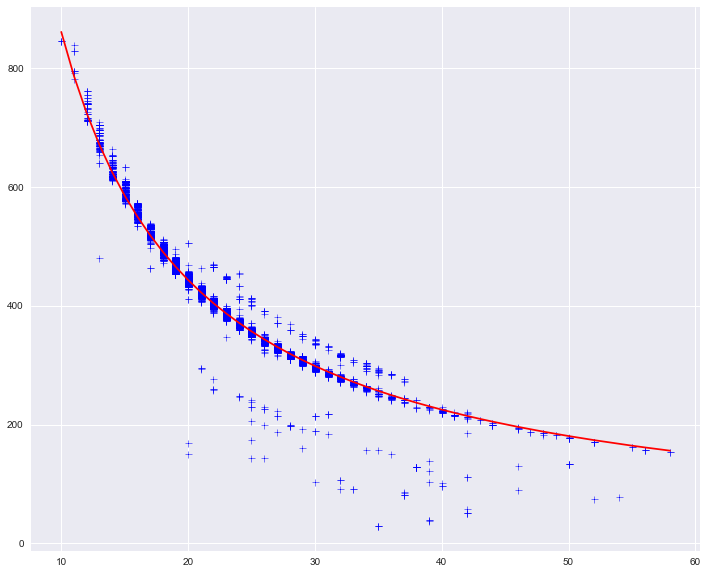

In [356]:
fig, axes = plt.subplots(figsize=(12,10))
axes.plot(epa_subset.comb08, epa_subset.co2, 'b+')
axes.plot(epa_subset.comb08.sort_values(), prediction, 'r')

## Logistic Regression

A [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is used to model data where the dependent variable is categorical. In the simplest case, the dependent variable is binary and has only two possible values.  A logistic model, provides an estimate of the probability that one of the two categories applies given the values of the independent variables.  We'll only look at simple case where the dependent variable is binary and there is only one independent variable.

### An Example 

As an example, consider the the following [example taken from the Wikipedia page on logistic regressions](https://en.wikipedia.org/wiki/Logistic_regression#Example:_Probability_of_passing_an_exam_versus_hours_of_study).  We have two variables: *hours* and *passed*.  The *hours* variable represents the number of hours a student spent studying for an exam and *passed* indicates whether or not the student passed the exam where `0` indicates failure and `1` indicates that the student passed; *hours* is a continuous variable and *passed* is a discrete, binary variable.

In [333]:
hours = [0.5, 0.75, 1.0, 1.25, 1.50, 1.75, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 4.0, 4.25, 4.5, 4.75, 5.0, 5.5]
passed = [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]

Plotting this data as a scatter plot give the following.

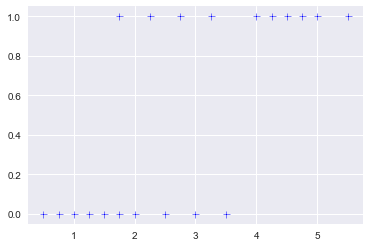

In [334]:
plt.plot(hours, passed, 'b+')

The logistic regression calculates values for $\beta_0$ and $\beta_1$ in the following formula

$$
\begin{array}{c}
P = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
\end{array}
$$

where $P$ is is a probability value between 0 and 1 and $X$ is the independent variable.

We can use the StatsModels [*Logit()*](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html) function to perform the logistic regression.  

We have to reassign the value of `stats.chisqprob` due to a discrepancy between the StatsModels module and the libraries on which it depends.

In [335]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

X = sm.add_constant(hours)
logit_model=sm.Logit(passed,X)
result=logit_model.fit()
display(result.summary())

Optimization terminated successfully.
         Current function value: 0.401494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Apr 2018   Pseudo R-squ.:                  0.4208
Time:                        18:58:05   Log-Likelihood:                -8.0299
converged:                       True   LL-Null:                       -13.863
                                        LLR p-value:                 0.0006365
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0777      1.761     -2.316      0.021      -7.529      -0.626
x1             1.5046      0.629      2.393      0.017       0.272       2.737
==============================================================================
"""

We create the model in much the same way as we did for a linear model.  We specify the independent variable and add a constant using StatsModels' *add_constant()* function.  We next create a logistic model using the *Logit()* function.  To calculate the coefficients, we use model's *fit()* method.  After the calculation is complete, we can view a summary of the results.

Just like the linear model, the results of the logistic model have a *predict()* method that give the model's predicted values based on the values of the independent variable.  We can use this to plot the logistic curve along with the scatter plot of the data. 

The model represents the probability of passing the exam given some number of hours spent studying.

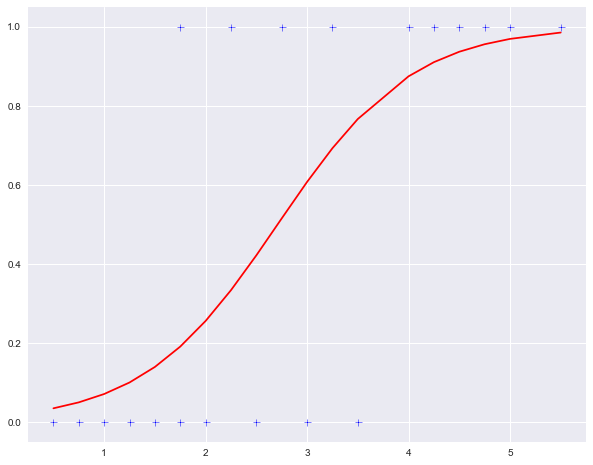

In [336]:
fig, axes = plt.subplots(figsize=(10,8))
axes.plot(hours,passed, 'b+')
axes.plot(hours, result.predict(), 'r-')


### Home Data

For an example with real data, consider the count auditor data we worked with previously.  We can load the data from our local database.

In [368]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/output.sqlite')
home_data = pd.read_sql("home_data", con=engine)
home_data.head()

,index,AirConditioning,AppraisedBuilding,AppraisedLand,Area,Bathrooms,Bedrooms,County,Fireplaces,Heat,Rooms,SalePrice,YearBuilt
0,0,True,59600.0,8100.0,2264,2.0,4.0,Franklin,0.0,True,10.0,0.0,1925.0
1,1,True,69800.0,4600.0,1835,1.5,4.0,Franklin,1.0,True,7.0,50000.0,1919.0
2,2,True,60600.0,4900.0,1656,1.0,3.0,Franklin,0.0,True,7.0,64000.0,1925.0
3,3,True,31200.0,5000.0,1000,1.0,2.0,Franklin,0.0,True,5.0,0.0,1922.0
4,4,True,63300.0,4600.0,1306,2.0,4.0,Franklin,0.0,True,6.0,0.0,1948.0


For this example, lets see if we can calculate the logistic model that gives the probability of a house having a fireplace given its area.  Currently, the dataset includes the the number of fireplaces a given property has; we need to convert values greater than zero to 1, indicating that there is a fireplace.  

First, we drop any rows with missing data. Next, we create a new column, `HasFireplace` that is equal to the mask corresponding the `Fireplaces` being greater than zero. Masks return values of `True` or `False` and the *astype(int)* function call will convert the boolean value to an integer where `False` becomes 0 and `True` becomes 1. 

In [369]:
home_data.dropna(inplace=True)
home_data['HasFireplace'] = (home_data.Fireplaces > 0).astype(int)
home_data.head()

,index,AirConditioning,AppraisedBuilding,AppraisedLand,Area,Bathrooms,Bedrooms,County,Fireplaces,Heat,Rooms,SalePrice,YearBuilt,HasFireplace
0,0,True,59600.0,8100.0,2264,2.0,4.0,Franklin,0.0,True,10.0,0.0,1925.0,0
1,1,True,69800.0,4600.0,1835,1.5,4.0,Franklin,1.0,True,7.0,50000.0,1919.0,1
2,2,True,60600.0,4900.0,1656,1.0,3.0,Franklin,0.0,True,7.0,64000.0,1925.0,0
3,3,True,31200.0,5000.0,1000,1.0,2.0,Franklin,0.0,True,5.0,0.0,1922.0,0
4,4,True,63300.0,4600.0,1306,2.0,4.0,Franklin,0.0,True,6.0,0.0,1948.0,0


We can now create the scatter plot of `Area` and `HasFireplaces

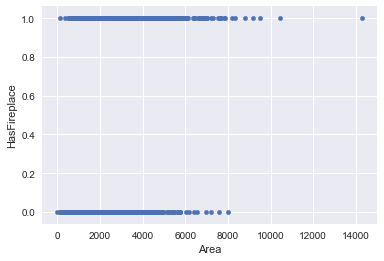

In [371]:
home_data.plot.scatter(x="Area", y="HasFireplace")

Before creating the model, we sort the values of our independent variable; this will aid in plotting later.

In [372]:
home_data.sort_values(by=["Area"], inplace=True)

Creating the logistic model and calculating the regression coefficients is similar to the logistic model as we noted in the example.

In [373]:
X = sm.add_constant(home_data.Area)
logit_model=sm.Logit(home_data.HasFireplace,X)
result=logit_model.fit()
display(result.summary())

Optimization terminated successfully.
         Current function value: 0.636377
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HasFireplace   No. Observations:                39236
Model:                          Logit   Df Residuals:                    39234
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Apr 2018   Pseudo R-squ.:                 0.05027
Time:                        19:32:38   Log-Likelihood:                -24969.
converged:                       True   LL-Null:                       -26291.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7215      0.029    -59.697      0.000      -1.778      -1.665
Area           0.0008   1.64e-05     47.992      0.000       0.001       0.001
==============================================================================
"""

With the model created and the coefficients calculated, we can now plot the regression curve against the original data.

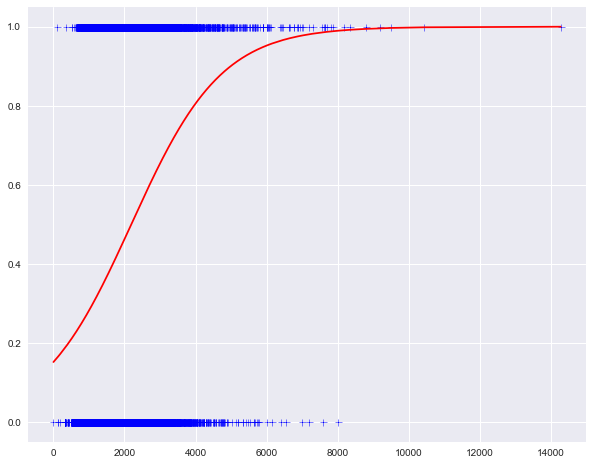

In [375]:
fig, axes = plt.subplots(figsize=(10,8))
axes.plot(home_data.Area, home_data.HasFireplace, 'b+')
axes.plot(home_data.Area, result.predict(), 'r-')


The formula for the curve is given by


$$
\begin{array}{c}
P = \frac{1}{1 + e^{-(-1.7215 + 0.0008 X)}}
\end{array}
$$

For a given area, we can calculate the probability that the house has a fireplace using this formula based on the model.

## Lab Answers


## Next Steps

The models we create can be used populate dashboards or included in reports. Later, we'll look at creating visualizations and reporting information. Model creation could also be an intermediate step in the analysis process; in a later unit we'll look at automating model creation.

## Resources and Further Reading

- [Simple and Multiple Linear Regression in Python](https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9)
- [Logistic Regression in Python Using Rodeo](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html)
- [Regression Analysis with Python by Massaron and Boschetti (Safari Books)](http://proquest.safaribooksonline.com.cscc.ohionet.org/book/programming/python/9781785286315)
- [Data Science Algorithms in a Week by Natingga, Regression (Safari Books)](http://proquest.safaribooksonline.com.cscc.ohionet.org/book/programming/machine-learning/9781787284586/regression/1500cb6b_9703_4b4a_bffb_61da8fbd2e97_xhtml?uicode=ohlink)

## Notes

1. <a name="note-1"></a> The null hypothesis being tested is that the variable associated with the coefficient has no effect on the dependent variable.  When the p-value is sufficiently low, typically less the 0.05, we reject the null hypothesis thereby accepting that the variable does have an effect on the dependent variable.

## Exercises

1. Calculate the coefficients for a linear model relating two columns from the fuel economy or county auditor data not discussed in the examples. Create a scatter plot of the data along with a plot of the regression line.
2. Calculate the coefficients for a logistic model relating two columns from the fuel economy or county auditor data not discussed in the examples. Create a scatter plot of the data along with a plot of the regression curve.